In [5]:
!pip install casadi
from IPython.display import clear_output
import os

import numpy as np
import casadi
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation
import time

if os.name == 'nt':
    plt.rcParams['font.family'] = 'MS Gothic'
elif os.name == 'posix':
    !pip install japanize-matplotlib


clear_output()

In [54]:
import casadi

L0 = 0.158
L1 = 0.78
L2 = 0.73
dt = 0.01
dead_time = 0.0
controller_dt = 0.01
l1=L1 / 2
l2=L2 / 2
M1=11.41
M2=50.14
I1=0.35
I2=0.25
c1=0
c2=0
g=9.8
Q = casadi.diag([5000,8000,7000,8500])
R = casadi.diag([0.02,0.01])
N = 400
horizon_dt = 0.01



t_min_a = -20  # 足首トルクの最小値
t_max_a = 20   # 足首トルクの最大値
t_min_h = -40  # 股関節トルクの最小値
t_max_h = 40   # 股関節トルクの最大値
theta1_min = -0.35
theta1_max = 0.53
theta2_min = -0.53
theta2_max = 0.87
theta1_dot_min = -casadi.inf
theta1_dot_max = casadi.inf
theta2_dot_min = -casadi.inf
theta2_dot_max = casadi.inf


nu = 2
nx = 4

x_ref = casadi.DM([0, 0, 0, 0])
u_ref = casadi.DM([0, 0])

total = nx*(N+1)+nu*N
print(f"total: {total}")

def make_f():
    states = casadi.SX.sym('states', nx)
    ctrls = casadi.SX.sym('ctrls', nu)

    q_a = states[0]
    q_h = states[1]
    dq_a = states[2]
    dq_h = states[3]

    tau_a = ctrls[0]
    tau_h = ctrls[1]

    sin_q_a = casadi.sin(q_a)
    cos_q_a = casadi.cos(q_a)
    sin_q_h = casadi.sin(q_h)
    cos_q_h = casadi.cos(q_h)
    sin_q_a_h = casadi.sin(q_a + q_h)
    cos_q_a_h = casadi.cos(q_a + q_h)

    # SX型で計算
    alpha1 = 1/4 * L1**2 * M1 + I1
    alpha2 = 1/4 * L2**2 * M2 + I2
    alpha3 = 1/2 * L1 * L2 * M2 * cos_q_h
    alpha4 = L1**2 * M2

    det_M = alpha2 * (alpha1 + alpha4) - alpha3**2

    # MX型からSX型に変更
    M_inv = casadi.SX(2, 2)  # 2x2行列の作成
    M_inv[0, 0] = alpha2 / det_M
    M_inv[0, 1] = -(alpha2 + alpha3) / det_M
    M_inv[1, 0] = -(alpha2 + alpha3) / det_M
    M_inv[1, 1] = (alpha1 + alpha2 + 2 * alpha3 + alpha4) / det_M

    f_1 = (
        tau_a + 1/2 * L1 * L2 * M2 * sin_q_h * dq_h**2 -
        L1 * L2 * M2 * sin_q_h * dq_a * dq_h +
        1/2 * g * L2 * M2 * sin_q_a_h +
        1/2 * g * L1 * M1 * sin_q_a -
        g * L1 * M2 * sin_q_a
    )
    f_2 = (
        tau_h - 1/2 * L1 * dq_a**2 * sin_q_h +
        1/2 * L2 * M2 * g * sin_q_a_h
    )

    f = casadi.vertcat(f_1, f_2)
    f = casadi.mtimes(M_inv, f)

    state_dot = casadi.vertcat(dq_a, dq_h, f)

    return casadi.Function('f', [states, ctrls], [state_dot])

def make_RK4():
    states = casadi.SX.sym('states',nx)
    ctrls = casadi.SX.sym('ctrls',nu)

    k1 = make_f()(states, ctrls)
    k2 = make_f()(states + dt * 1/2 * k1, ctrls)
    k3 = make_f()(states + dt * 1/2 * k2, ctrls)
    k4 = make_f()(states + dt * k3, ctrls)

    states_next = states + 1/6 * (k1 + 2*k2 + 2*k3 + k4)

    return casadi.Function('RK4', [states, ctrls], [states_next],["x","u"],["x_next"])  

def make_integrater():
    states = casadi.SX.sym('states',nx)
    ctrls = casadi.SX.sym('ctrls',nu)

    f=make_f()
    ode = f(states,ctrls)
    dae = {'x':states,'p':ctrls,'ode':ode}

    I = casadi.integrator('I','cvodes',dae,0,dt)
    return I

def compute_stage_cost(x,u):
    x_diff = x - x_ref
    u_diff = u - u_ref
    cost = (casadi.dot(Q@x_diff,x_diff) + casadi.dot(R@u_diff,u_diff))/2
    return cost

def compute_terminal_cost(x):
    x_diff = x - x_ref
    cost = casadi.dot(Q@x_diff,x_diff)/2
    return cost


def make_nlp():
    RK4 = make_RK4()
    U = [casadi.SX.sym(f'u_{i}',nu) for i in range(N)]
    X = [casadi.SX.sym(f'x_{i}',nx) for i in range(N+1)]
    G = []

    J = 0

    for i in range(N):
        J += compute_stage_cost(X[i],U[i])*dt
        eq = X[i+1] - RK4(X[i],U[i])
        G.append(eq)
    J += compute_terminal_cost(X[-1])

    option = {"print_time":False,
              "ipopt":{"max_iter":10,"print_level":0}}
    nlp = {"x":casadi.vertcat(*X,*U),"f":J,"g":casadi.vertcat(*G)}
    S = casadi.nlpsol("S","ipopt",nlp,option)
    return S

def compute_optimal_control(S,x_init,x0):
    print("in compute_optimal_control-----------------")
    x_init = x_init.full().ravel().tolist()
    print(f"x_init: {x_init}")


    # 状態変数と制御変数の制約設定
    lbx = x_init + [theta1_min] * N + [theta2_min] * N + [theta1_dot_min] * N + [theta2_dot_min] * N  # 状態変数の下限
    ubx = x_init + [theta1_max] * N + [theta2_max] * N + [theta1_dot_max] * N + [theta2_dot_max] * N  # 状態変数の上限
    lbx += [t_min_a] * N + [t_min_h] * N  # 制御入力の下限（足首と股関節トルク）
    ubx += [t_max_a] * N + [t_max_h] * N  # 制御入力の上限（足首と股関節トルク）

    # 状態制約と制御制約の次元数が合っているか確認
    print(f"lbx size: {len(lbx)}, ubx size: {len(ubx)}")

    lbg = [0]*nx*N
    ubg = [0]*nx*N

    res = S(lbx=lbx,ubx=ubx,lbg=lbg,ubg=ubg,x0=x0)

    offset = nx*(N+1)
    x0 = res["x"]
    u_opt = x0[offset:offset+nu]
    return u_opt,x0


t_span = [0,10]
t_eval = np.arange(*t_span,dt)

x_init = casadi.DM([0.0873,0,0,0])
x0 = casadi.DM.zeros(total)

S = make_nlp()
T = make_integrater()

X = [x_init]
U = []
x_current = x_init
for t in t_eval:
    u_opt,x0 = compute_optimal_control(S,x_current,x0)
    x_current = T(x0=x_current, p=u_opt)["xf"]
    X.append(x_current)
    U.append(u_opt)

X.pop()
X = np.array(X).reshape(t_eval.size,nx)
U = np.array(U).reshape(t_eval.size,nu)

total: 2404
in compute_optimal_control-----------------
x_init: [0.0873, 0.0, 0.0, 0.0]
lbx size: 2404, ubx size: 2404
in compute_optimal_control-----------------
x_init: [0.08729741968508774, 4.673184383091901e-08, -0.0005050905243480436, 6.2057094946678e-06]
lbx size: 2404, ubx size: 2404
in compute_optimal_control-----------------
x_init: [0.08728986672757971, 1.8420434258473053e-07, -0.0010023955418482131, 1.2590610681231439e-05]
lbx size: 2404, ubx size: 2404
in compute_optimal_control-----------------
x_init: [0.08727737114796985, 4.128419709129802e-07, -0.0014918872425538278, 1.8769192581435837e-05]
lbx size: 2404, ubx size: 2404
in compute_optimal_control-----------------
x_init: [0.08726001083443187, 7.303597774349177e-07, -0.001973667387483265, 2.4771798149945452e-05]
lbx size: 2404, ubx size: 2404
in compute_optimal_control-----------------
x_init: [0.08723786305465796, 1.1324017531873955e-06, -0.0024478138919876444, 3.055607995175624e-05]
lbx size: 2404, ubx size: 2404
in c

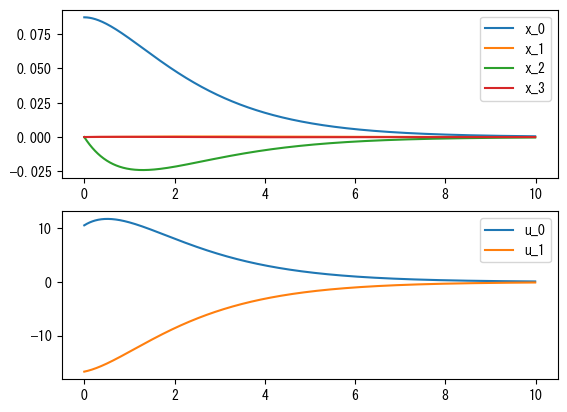

In [55]:
plt.figure()

plt.subplot(2,1,1)
for k in range(nx):
    plt.plot(t_eval,X[:,k],label=f"x_{k}")
plt.legend()

plt.subplot(2,1,2)
for k in range(nu):
    plt.plot(t_eval,U[:,k],label=f"u_{k}")
plt.legend()

plt.show()

In [62]:
import numpy as np
import pandas as pd

# Xはt_eval.size行、nx列のNumPy配列
df = pd.DataFrame(X, columns=[f"state_{i+1}" for i in range(nx)])


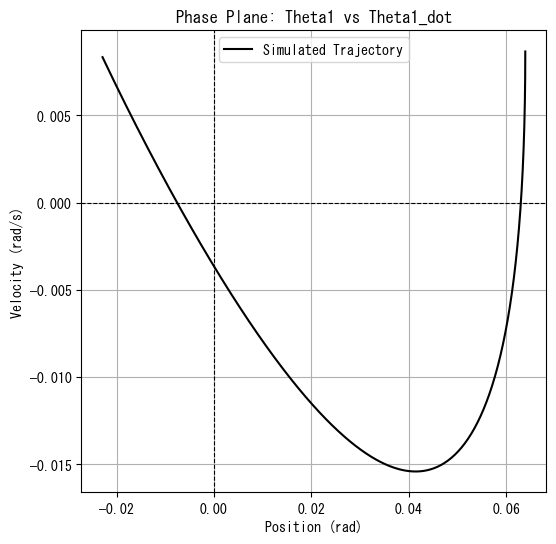

In [59]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ラジアンのまま処理
angle1 = df['state_1']  # 角度（ラジアン）
angular_velocity1 = df['state_3']  # 角速度（ラジアン/秒）

# 平均を引いて中心を原点に揃える
angle1_centered = angle1 - np.mean(angle1)
angular_velocity1_centered = angular_velocity1 - np.mean(angular_velocity1)

# グラフの作成
plt.figure(figsize=(6, 6))
plt.plot(angle1_centered, angular_velocity1_centered, 'k-', label="Simulated Trajectory")  # 黒実線


# 軸ラベルと範囲設定
plt.xlabel("Position (rad)")
plt.ylabel("Velocity (rad/s)")
plt.title("Phase Plane: Theta1 vs Theta1_dot")

# 軸を中心に設定
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')  # y軸の中心線
plt.axvline(0, color='black', linewidth=0.8, linestyle='--')  # x軸の中心線

# 凡例とグリッド
plt.legend()
plt.grid()

# グラフの表示
plt.show()

In [60]:
df

,state_1,state_2,state_3,state_4
0,0.087300,0.000000e+00,0.000000,0.000000
1,0.087297,4.673184e-08,-0.000505,0.000006
2,0.087290,1.842043e-07,-0.001002,0.000013
3,0.087277,4.128420e-07,-0.001492,0.000019
4,0.087260,7.303598e-07,-0.001974,0.000025
...,...,...,...,...
995,0.000559,1.867488e-05,-0.000333,-0.000014
996,0.000556,1.855213e-05,-0.000331,-0.000014
997,0.000553,1.842997e-05,-0.000329,-0.000014
998,0.000549,1.830840e-05,-0.000327,-0.000014
